In [1]:
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model
import tensorflow as tf

In [2]:
cascade_path = 'model/cv2/haarcascade_frontalface_alt2.xml'
model_path = 'model/keras/model/facenet_keras.h5'
image_dir_basepath = 'data/images/images/'
image_size = 160

In [3]:
def loadModel():
    model = load_model(model_path)

In [4]:
model = load_model(model_path)

In [5]:
def prewhiten(x):
        if x.ndim == 4:
            axis = (1, 2, 3)
            size = x[0].size
        elif x.ndim == 3:
            axis = (0, 1, 2)
            size = x.size
        else:
            raise ValueError('Dimension should be 3 or 4')

        mean = np.mean(x, axis=axis, keepdims=True)
        std = np.std(x, axis=axis, keepdims=True)
        std_adj = np.maximum(std, 1.0/np.sqrt(size))
        y = (x - mean) / std_adj
        return y

In [6]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [7]:
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    aligned_images = []
    empty=[]
    for filepath in filepaths:
        img = imread(filepath)
        faces = cascade.detectMultiScale(img)
        if(len(faces)>0):
            (x, y, w, h) = faces[0]
            cropped = img[y-margin//2:y+h+margin//2, x-margin//2:x+w+margin//2, :]
            aligned = resize(cropped, (image_size, image_size), mode='reflect')
            aligned_images.append(aligned)
        else:
            empty.append(filepath)
    return np.array(aligned_images)

In [8]:
def img2vec(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))
    return embs

In [9]:
def calc_dist(img_name0, img_name1):
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

In [10]:
def addInd(file):
    return file+"0"

In [11]:
data ={}
filepaths = os.listdir(image_dir_basepath)
for file in filepaths:
    image_dirpath = image_dir_basepath + file
    image_filepaths = [image_dirpath]
    embs = img2vec(image_filepaths)
    for i in range(len(image_filepaths)):
        data['{}{}'.format(file, i)] = {'image_filepath' : image_filepaths[i], 'emb' : embs[i]}

C:\Users\Patron\anaconda3\envs\Tensorflow_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


In [12]:
inputImage = "005121.jpg"

In [13]:
dData = data.copy()
dData.pop(addInd(inputImage))
outPutDict = dData

In [14]:
inputDict = { addInd(inputImage) :  data.get(addInd(inputImage)) }

In [15]:
allDistances = []
for out in outPutDict:
    euclideanDistance = calc_dist(addInd(inputImage), out)
    allDistances.append([euclideanDistance, out])

In [16]:
nearestImages = sorted(allDistances, key=lambda x: x[0], reverse = True )[-5:]

In [17]:
nearestImages

[[0.5680062770843506, '057094.jpg0'],
 [0.5660986304283142, '018678.jpg0'],
 [0.5612706542015076, '123091.jpg0'],
 [0.541905403137207, '127605.jpg0'],
 [0.5171207189559937, '049465.jpg0']]

C:\Users\Patron\anaconda3\envs\Tensorflow_env\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  after removing the cwd from sys.path.
C:\Users\Patron\anaconda3\envs\Tensorflow_env\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


<Figure size 640x480 with 0 Axes>

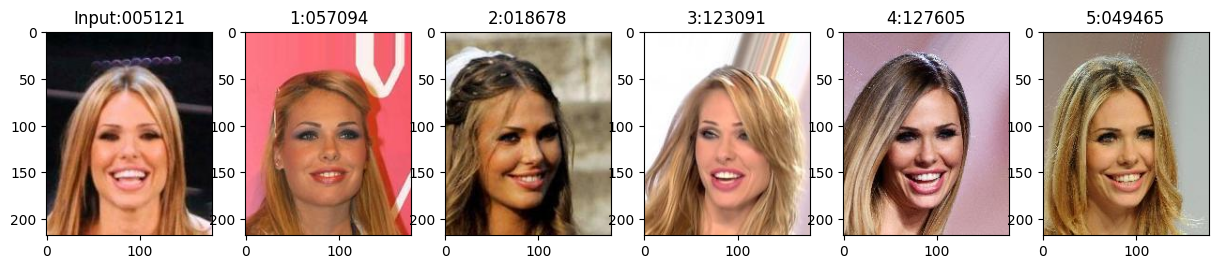

In [18]:
plt.figure()
f, axarr = plt.subplots(1,6, figsize=(15, 15)) 

axarr[0].imshow(imread(image_dir_basepath+inputImage))
axarr[0].set_title("Input:"+inputImage[0:6])

for i in range(len(nearestImages)):
    axarr[i+1].imshow(imread(image_dir_basepath+nearestImages[i][1][0:10]))
    axarr[i+1].set_title(str(i+1)+":"+nearestImages[i][1][0:6])